<a href="https://colab.research.google.com/github/xiao-nx/COVID-19_Hebei/blob/main/SEIR_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Epidemiology model

https://nbviewer.jupyter.org/github/pyro-ppl/pyro/blob/sir-tutorial-ii/tutorial/source/epi_regional.ipynb?fbclid=IwAR3Gv8tLuiEjOmZh7-NQUa_ggm_QUqtSc5TxRZ0_pSxVA7Y3lWWzSFGKjrA 


In [ ]:
!git clone https://github.com/pyro-ppl/pyro.git

fatal: destination path 'pyro' already exists and is not an empty directory.


In [ ]:
%cd /content/pyro


/content/pyro


In [ ]:
!pip install .[extras]

Processing /content/pyro
  Created wheel for pyro-ppl: filename=pyro_ppl-1.5.2+eb490970-cp36-none-any.whl size=629144 sha256=908361a20cdc7e6163cd2146610af268d7aeb1e142d495474cb7a2ee11911a76
  Stored in directory: /tmp/pip-ephem-wheel-cache-svmrs833/wheels/7f/c8/0f/f4e71d6e55e68c8a64c8382f3f6eb829e6aa18323499202e37
Successfully built pyro-ppl
  Found existing installation: pyro-ppl 1.5.2+eb490970
    Uninstalling pyro-ppl-1.5.2+eb490970:
      Successfully uninstalled pyro-ppl-1.5.2+eb490970


In [ ]:
import os
import logging
import urllib.request
from collections import OrderedDict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import pyro
import pyro.distributions as dist
from pyro.contrib.epidemiology import CompartmentalModel, binomial_dist, infection_dist
from pyro.ops.tensor_utils import convolve

%matplotlib inline
pyro.enable_validation(True)           
torch.set_default_dtype(torch.double) 


  ## Model without Policies
  

In [ ]:
class CovidModel(CompartmentalModel):
  def __init__(self, population, new_cases):
    '''
    population (int) – Total population = S + E + I + R.
    '''
    compartments = ("S", "E", "I")  # R is implicit.
    duration = len(new_cases)
    super().__init__(compartments, duration, population)

    self.new_cases = new_cases
        

  def global_model(self):
    
    beta = pyro.sample("infectious_rate", dist.Beta(10, 10))
    alpha = pyro.sample("incubation_time",dist.Normal(5.0, 1))
    gamma = pyro.sample("recovery_time",dist.Normal(15.0, 1))
    R0 = pyro.sample("R0", dist.Normal(2, 0.5))


    # tau_e = pyro.sample("rec_time",dist.Normal(15.0, 1))
    # tau_i = pyro.sample("incub_time",dist.Normal(5.0, 1))
    # R0 = pyro.sample("R0", dist.Normal(2, 0.5))
    # rho = pyro.sample("rho", dist.Beta(10, 10))

    return R0, beta, alpha, gamma

  def initialize(self, params):
    # Start with a single infection.
    return {"S": self.population - 1, "E": 0, "I": 1}

  def transition(self, params, state, t):
    R0, beta, alpha, gamma = params

    # Sample flows between compartments.
    S2E = pyro.sample("S2E_{}".format(t),
              infection_dist(individual_rate=R0/gamma,
              num_susceptible=state["S"],
              num_infectious=state["I"],
              population=self.population))
    E2I = pyro.sample("E2I_{}".format(t),
              binomial_dist(state["E"], 1/alpha)) 
    I2R = pyro.sample("I2R_{}".format(t),
              binomial_dist(state["I"], 1/gamma))

    # Update compartments with flows.
    state["S"] = state["S"] - S2E 
    state["E"] = state["E"] + S2E - E2I
    state["I"] = state["I"] + E2I - I2R

    # Condition on observations.
    t_is_observed = isinstance(t, slice) or t < self.duration
    pyro.sample("new_cases_{}".format(t),
          binomial_dist(S2E,beta),
          obs=self.new_cases[t] if t_is_observed else None)
    # pyro.sample("new_deaths_{}".format(t),
    #       binomial_dist(I2R, mort_rate),
    #       obs=self.new_deaths[t] if t_is_observed else None)
    # pyro.sample("new_recovered_{}".format(t),
    #       binomial_dist(E2I, rec_rate),
    #       obs=self.new_recovered[t] if t_is_observed else None)


## Create Country

In [ ]:
# function to make the time series of confirmed and daily confirmed cases for a specific country
def generate_data(start_date, end_date, state = False) : 

  df = pd.read_csv("/Hebei.csv")
  
  # convert date string to datetime
  df.Date = pd.to_datetime(df.Date)
  df = df.sort_values(by = "Date")
  df = df[df.Date >= start_date]
  df = df[df.Date <= end_date]

  new_cases = df['daily_confirmed_shijiazhuang'].tolist()

  new_cases = torch.tensor(list(map(float, new_cases))).view(len(new_cases),1) 

  return_data = {
      'new_cases':new_cases
      }
      
  return return_data


## Get data for countries


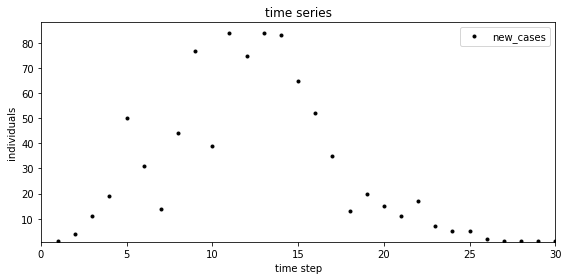

In [ ]:
Shijiazhuang = generate_data(start_date = "2021-01-01", end_date = "2021-01-31")

plt.figure(figsize=(8,4))
new_cases = Shijiazhuang["new_cases"]
plt.plot(new_cases,"k.", label="new_cases")
plt.xlim(0, len(new_cases) - 1)
plt.ylim(0.8, None)
plt.xlabel("time step")
plt.ylabel("individuals")
plt.legend(loc="best")
plt.title("time series")
plt.tight_layout()

##Train the model using MCMC.



In [ ]:
Shijiazhuang_model = CovidModel(10520000, Shijiazhuang["new_cases"])

In [ ]:
%%time
pyro.set_rng_seed(20200607)
Shijiazhuang_mcmc = Shijiazhuang_model.fit_mcmc(num_samples=200)

INFO 	 Running inference...
Sample: 100%|██████████| 400/400 [01:25,  4.70it/s, step size=2.67e-03, acc. prob=0.893]

CPU times: user 1min 24s, sys: 334 ms, total: 1min 24s
Wall time: 1min 25s


In [ ]:
Shijiazhuang_mcmc.summary()


                       mean       std    median      5.0%     95.0%     n_eff     r_hat
  infectious_rate      0.43      0.01      0.43      0.42      0.45      2.65      2.33
  incubation_time      4.48      0.16      4.45      4.26      4.73      2.60      2.41
    recovery_time     15.16      0.10     15.14     15.01     15.33      2.59      2.44
               R0      3.53      0.26      3.58      3.10      3.90      2.62      2.38
   auxiliary[0,0] 10519941.58      3.36 10519940.56 10519937.17 10519946.82      2.61      2.62
   auxiliary[0,1] 10519882.72      6.47 10519880.85 10519875.18 10519893.71      2.52      2.63
   auxiliary[0,2] 10519823.41      9.41 10519821.00 10519811.71 10519838.92      2.51      2.61
   auxiliary[0,3] 10519763.60     12.45 10519761.05 10519747.30 10519782.77      2.51      2.59
   auxiliary[0,4] 10519703.40     15.47 10519700.74 10519682.01 10519726.91      2.52      2.54
   auxiliary[0,5] 10519642.87     18.33 10519639.35 10519616.53 10519670.44    

Prediction


In [ ]:
samples = Shijiazhuang_model.predict()
for key, value in sorted(samples.items()):
  print("{}.shape = {}".format(key, tuple(value.shape)))


INFO 	 Predicting latent variables for 31 time steps...


E.shape = (200, 31)
E2I.shape = (200, 31)
I.shape = (200, 31)
I2R.shape = (200, 31)
R0.shape = (200, 1)
S.shape = (200, 31)
S2E.shape = (200, 31)
auxiliary.shape = (200, 1, 3, 31)
incubation_time.shape = (200, 1)
infectious_rate.shape = (200, 1)
new_cases.shape = (200, 31)
recovery_time.shape = (200, 1)


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


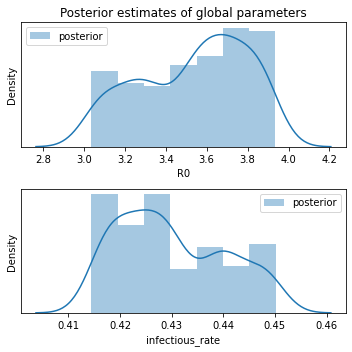

In [ ]:
names = ["R0", "infectious_rate"]
fig, axes = plt.subplots(2, 1, figsize=(5, 5))
axes[0].set_title("Posterior estimates of global parameters")
for ax, name in zip(axes, names):
    # truth = synth_data[name]
    sns.distplot(samples[name], ax=ax, label="posterior")
    # ax.axvline(truth, color="k", label="truth")
    ax.set_xlabel(name)
    ax.set_yticks(())
    ax.legend(loc="best")
plt.tight_layout()

Forecasting


In [ ]:
def plot_forecast(samples,duration,obs):
    # duration = len(empty_data)
    forecast = samples["S"].size(-1) - duration
    num_samples = len(samples["R0"])

    time = torch.arange(duration + forecast)
    # S2I = samples["S2E"]
    S2I = samples["E2I"]
    median = S2I.median(dim=0).values
    p05 = S2I.kthvalue(int(round(0.5 + 0.05 * num_samples)), dim=0).values
    p95 = S2I.kthvalue(int(round(0.5 + 0.95 * num_samples)), dim=0).values

    plt.figure(figsize=(8, 4))
    plt.fill_between(time, p05, p95, color="red", alpha=0.3, label="90% CI")
    plt.plot(time, median, "r-", label="median")
    plt.plot(time[:duration], obs, "k.", label="observed")
    # plt.plot(time[:duration], synth_data["S2E"], "k--", label="truth")

    plt.axvline(duration - 0.5, color="gray", lw=1)
    plt.xlim(0, len(time) - 1)
    plt.ylim(0, None)
    plt.xlabel("day after first infection")
    plt.ylabel("new infections per day")
    plt.title("New infections in population of {}".format(population))
    plt.legend(loc="upper left")
    plt.tight_layout()


INFO 	 Predicting latent variables for 31 time steps...
INFO 	 Forecasting 7 steps ahead...


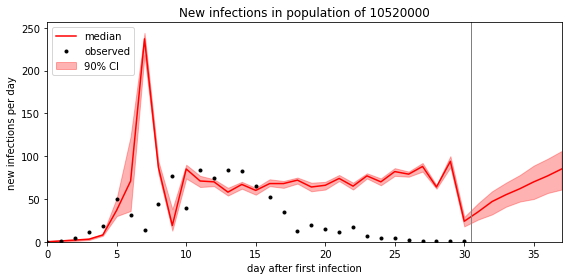

In [ ]:
# empty_data = [None] * 30
duration = len(Shijiazhuang["new_cases"])
population = 10520000
df = pd.read_csv("/Hebei.csv")
  
obs = Shijiazhuang["new_cases"]


samples = Shijiazhuang_model.predict(forecast=7)
plot_forecast(samples,duration,obs)